1.2 GMM and Kmeans

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Kmeans

In [82]:
#1. pick random k centers
def _init_centroids(data,k):
  indices = np.random.choice(data.shape[0],k)
  return data[indices,]

#2. find closest center for each point
def _find_clusters(data,centroids):
  dist = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2) #euclidean
  return np.argmin(dist,axis=1)

#3. update centroids by taking the mean of all points within the cluster
def _update_centroids(data, clusters, k):
  updated = np.zeros((k,data.shape[1]))
  for k_i in range(k):
    updated[k_i] = np.mean(data[clusters==k_i],axis=0)
  return updated

#Generate synthetic data
#Run kmeans with 1-3 steps until it converges
def _kmeans(data,k,iter):
  center = _init_centroids(data,k)
  for i in range(iter):
    cluster = _find_clusters(data,center)
    center = _update_centroids(data,cluster,k)
  return center, cluster

def eval_kmeans_sigma(sigma_list, k=3, iter=1000):
  av_distances, accuracies = [],[]

  mu1 = np.array([-1,-1])
  mu2 = np.array([1,-1])
  mu3 = np.array([0,1])
  true_centers = np.vstack((mu1,mu2,mu3))

  #make a df with each sigma*cov
  for sigma in sigma_list:
    d1 = np.random.multivariate_normal(mu1,
                                       sigma*np.array([[2,0.5],[0.5,1]]),
                                       100)
    d2 = np.random.multivariate_normal(mu2,
                                       sigma*np.array([[1,-0.5],[-0.5,2]]),
                                       100)
    d3 = np.random.multivariate_normal(mu3,
                                       sigma*np.array([[1,0],[0,2]]),
                                       100)

    data1 = np.hstack((d1,np.full((d1.shape[0],1),1)))
    data2 = np.hstack((d2,np.full((d2.shape[0],1),2)))
    data3 = np.hstack((d3,np.full((d3.shape[0],1),3)))
    data = np.vstack((data1,data2,data3))

    true_clusters = data[:,2]


    #found centers
    pred_centers, pred_clusters = _kmeans(data[:,:2],k,iter)

    accuracies.append(sum(true_clusters != pred_clusters)/len(true_clusters))
    #compute MSE
    av_dist = np.mean(np.abs(true_centers-pred_centers))
    av_distances.append(av_dist)
  return np.array([sigma_list, av_distances]), np.array([sigma_list, accuracies])

sigma_list = [0.5,1,2,4,8]

kmeans_dist, kmeans_acc = eval_kmeans_sigma(sigma_list)

In [99]:
kmeans_dist, kmeans_acc

(array([[0.5       , 1.        , 2.        , 4.        , 8.        ],
        [0.18422008, 0.98598439, 0.5325211 , 1.93379875, 2.49396081]]),
 array([[0.5       , 1.        , 2.        , 4.        , 8.        ],
        [0.88      , 0.69666667, 0.81666667, 0.87666667, 0.77      ]]))

Text(0.5, 1.0, 'KMeans evaluation')

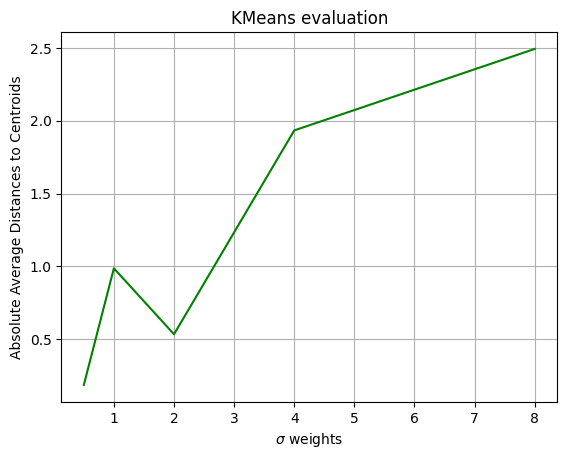

In [85]:
plt.plot(kmeans_dist[0,:],kmeans_dist[1,:],label="Kmeans",c="green")
plt.grid()
plt.xlabel("$\sigma$ weights")
plt.ylabel("Absolute Average Distances to Centroids")
plt.title("KMeans evaluation (objective)")

GMM

In [92]:
import numpy as np

def _mvn(x, mean, cov):
    n = len(mean)
    cov_inv = np.linalg.inv(cov)
    return (1 /((2 * np.pi) ** (n / 2) * np.sqrt(np.linalg.det(cov)))) * np.exp(-0.5 * np.dot(np.dot((x - mean).T, cov_inv), x - mean))

#estimate posterior based on current params (means,cov,w)
def _E_step(data, mu, sigma, w):
    n_samples, n_features = data.shape
    k = len(mu)
    posteriors = np.zeros((n_samples, k))
    data_likelihood = np.zeros((n_samples,1))

    #gaussian posterior
    for i in range(n_samples):
        for k_i in range(k):
            posteriors[i, k_i] = w[k_i] * _mvn(data[i], mu[k_i], sigma[k_i])
        data_likelihood[i] = np.sum(posteriors[i])
        posteriors[i] /= np.sum(posteriors[i])

    return posteriors, data_likelihood

#fix w, update params ie. max posteriors
def _M_step(data, posteriors):
    n_samples, K = posteriors.shape
    n_features = data.shape[1]
    new_means = np.zeros((K, n_features))
    new_cov = [np.zeros((n_features, n_features)) for _ in range(K)]
    new_w = np.zeros(K)

    for k_i in range(K):
        Nk = np.sum(posteriors[:, k_i])
        new_w[k_i] = Nk #phi_j

        for i in range(n_samples):
            diff = data[i] - new_means[k_i]
            new_means[k_i] += posteriors[i, k_i] * data[i] #mu_j: posteriors as soft w
            new_cov[k_i] += posteriors[i, k_i] * np.outer(diff, diff) #cov_j

        new_means[k_i] /= Nk
        new_cov[k_i] /= Nk
    new_w /= n_samples
    return new_means, new_cov, new_w

def gmm_EM(data, k, iter=1000, epsilon=0.001):
    n_samples, n_features = data.shape
    mu = data[np.random.choice(n_samples, k, replace=False)] #random
    sigma = [np.eye(n_features)] * k #cov identity
    w = np.ones(k) / k

    for i in range(iter):
        posteriors, likelihood = _E_step(data, mu, sigma, w) #same posteriors..?
        obj = np.mean(np.sum(likelihood,axis=1))
        new_means, new_cov_mat, new_w = _M_step(data, posteriors)

        #converged
        if np.all(np.isclose(mu, new_means, rtol=epsilon)) and np.all(np.isclose(w, new_w, rtol=epsilon)):
            break
        #else: continue
        #means, covariances, weights = new_means, new_cov_mat, new_w
    return new_means, np.argmax(posteriors,axis=1), -np.log(obj)

# d1 = np.random.multivariate_normal(np.array([-1,-1]),
#                                    np.array([[2,0.5],[0.5,1]]),100)
# gmm_EM(d1,3)

In [93]:
def eval_gmm_sigma(sigma_list):
  objectives, accuracies = [], []
  mu1 = np.array([-1,-1])
  mu2 = np.array([1,-1])
  mu3 = np.array([0,1])
  true_means = np.vstack((mu1,mu2,mu3))

  #make a df with each sigma*cov
  for sigma in sigma_list:
    d1 = np.random.multivariate_normal(mu1,
                                       sigma*np.array([[2,0.5],[0.5,1]]),
                                       100)
    d2 = np.random.multivariate_normal(mu2,
                                       sigma*np.array([[1,-0.5],[-0.5,2]]),
                                       100)
    d3 = np.random.multivariate_normal(mu3,
                                       sigma*np.array([[1,0],[0,2]]),
                                       100)

    data1 = np.hstack((d1,np.full((d1.shape[0],1),1)))
    data2 = np.hstack((d2,np.full((d2.shape[0],1),2)))
    data3 = np.hstack((d3,np.full((d3.shape[0],1),3)))
    data = np.vstack((data1,data2,data3))

    new_means, assignment, obj = gmm_EM(data[:,:2], 3)
    objectives.append(obj)
    accuracies.append(sum(assignment != data[:,2])/len(assignment))

  return np.array([sigma_list, objectives]), np.array([sigma_list, accuracies])

sigma_list = [0.5,1,2,4,8]
gmm_obj, gmm_acc = eval_gmm_sigma(sigma_list)

In [98]:
gmm_obj, gmm_acc

(array([[0.5       , 1.        , 2.        , 4.        , 8.        ],
        [3.53160828, 3.40250773, 3.69536199, 4.83075043, 4.98541008]]),
 array([[0.5       , 1.        , 2.        , 4.        , 8.        ],
        [0.63666667, 0.92      , 0.84      , 0.76      , 0.79333333]]))

Text(0.5, 1.0, 'Clustering Accuracies')

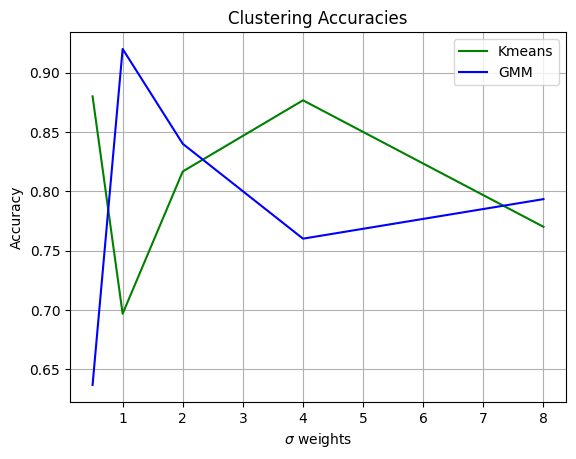

In [94]:
plt.plot(kmeans_acc[0,:],kmeans_acc[1,:],label="Kmeans",c="green")
plt.plot(gmm_acc[0,:],gmm_acc[1,:],label="GMM",c="blue")
plt.grid()
plt.xlabel("$\sigma$ weights")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Clustering Accuracies")

Text(0.5, 1.0, 'GMM evaluation')

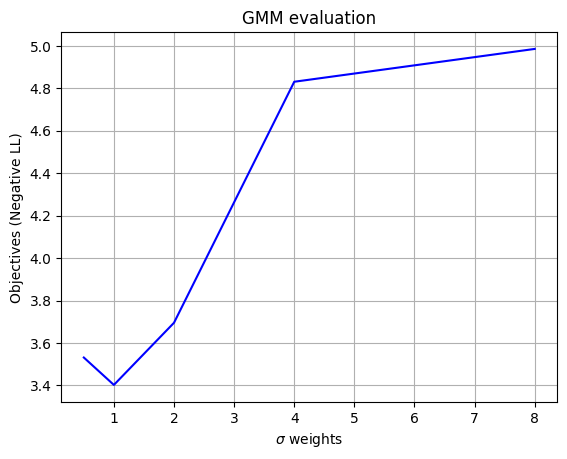

In [96]:
plt.plot(gmm_obj[0,:],gmm_obj[1,:],label="GMM",c="blue")
plt.grid()
plt.xlabel("$\sigma$ weights")
plt.ylabel("Objectives (Negative LL)")
plt.title("GMM evaluation")

In [100]:
# plt.plot(kmeans_output[0,:],kmeans_output[1,:],label="Kmeans",c="blue")
# plt.plot(gmm_output[0,:],gmm_output[1,:],label="GMM",c="green")
# plt.xticks(kmeans_output[0,:])
# plt.grid()
# plt.xlabel("$\sigma$ weights")
# plt.ylabel("Predicted centroid MSE")
# plt.title("Clustering Evaluation")
# plt.legend()

2.1 PCA

In [3]:
import pandas as pd
data2d = pd.read_csv("data2D.csv",header=None)
data2d.head()

,0,1
0,7.268685,5.376181
1,4.305895,5.949352
2,5.038183,5.936941
3,7.472772,5.168404
4,6.294955,5.404687


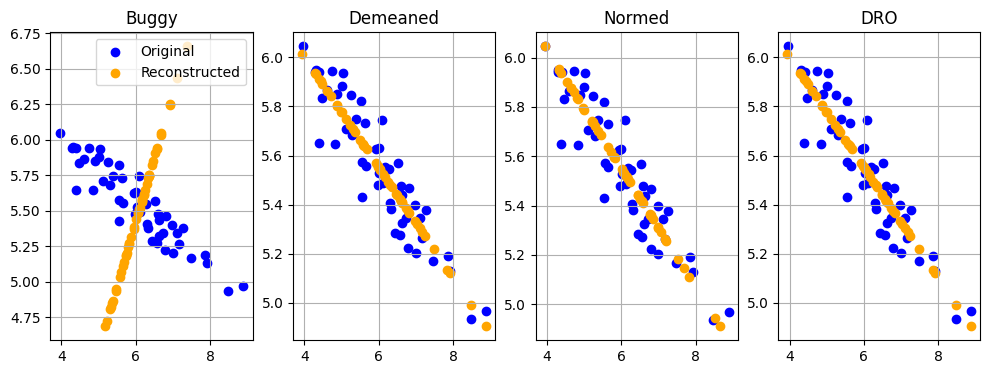

In [41]:
def buggy_pca(data,d):
  left_singular, diag, right_singular_T = np.linalg.svd(data, full_matrices=False)
  top_d_pc = right_singular_T[:d,:] #choose top d components
  data_hat = data @ top_d_pc.T @ top_d_pc #reduced
  return data_hat

def demeaned_pca(data,d):
  mean = np.mean(data,axis=0)
  demeaned_data = data - mean
  demeaned_hat = buggy_pca(demeaned_data,d)
  return demeaned_hat + mean #adding mean back in

def normalized_pca(data,d):
  mean = np.mean(data,axis=0)
  sd = np.std(data,axis=0)
  normed_data = (data - mean)/sd
  normed_hat = buggy_pca(normed_data,d)
  return normed_hat*sd + mean


def dro_pca(data,d,returnDiag=False):
    b = np.mean(np.array(data),axis=0) #2 x 1
    demeaned_data = data - b #50 x 2
    left_singular, diag, right_singular = np.linalg.svd(demeaned_data, full_matrices=False)
    if returnDiag:
        return diag
    z = left_singular[:,:d]
    a = right_singular[:d].T @ np.diag(diag[:d])
    data_hat = z @ a.T + b
    return pd.DataFrame(data_hat)


def reconst_error(data,data_hat):
    return sum(np.sum((data-data_hat)**2))

#Returns 2 Dict
#(1) A dict of each reconstructed points (y-hat) for all 4 methods
# 1. bugggy 2. demeaned 3. normalized 4. dro

#(2) A dict of MSE array for 4 methods
def eval_all_methods(data,d):
  #run PCA
  buggy_hat = buggy_pca(data,d)
  demeaned_hat = demeaned_pca(data,d)
  normed_hat = normalized_pca(data,d)
  dro_hat = dro_pca(data,d,returnDiag=False)

  #compute MSE
  buggy_err = reconst_error(data, buggy_hat)
  demean_err = reconst_error(data, demeaned_hat)
  normed_err = reconst_error(data, normed_hat)
  dro_err = reconst_error(data, dro_hat)

  return {"buggy":buggy_hat,
          "demeaned": demeaned_hat,
          "normed":normed_hat,
          "dro":dro_hat}, {"buggy":buggy_err,
        "demeaned":demean_err,
        "normed":normed_err,
        "dro":dro_err}

def plot(ax, data,data_hat,title,legend_off=True):
  #plt.figure(figsize=(4,3))
  ax.scatter(data.iloc[:,0],data.iloc[:,1],label="Original",c="blue")
  ax.scatter(data_hat.iloc[:,0],data_hat.iloc[:,1],label="Reconstructed",c="orange")
  if not legend_off:
    ax.legend()
  ax.grid()
  ax.set_title(title)

y_hats, errors = eval_all_methods(data2d,d=1)

fig,axes = plt.subplots(1,4, figsize=(12,4))
plot(axes[0], data2d,y_hats["buggy"],"Buggy",False)
plot(axes[1],data2d,y_hats["demeaned"],"Demeaned")
plot(axes[2],data2d,y_hats["normed"],"Normed")
plot(axes[3],data2d,y_hats["dro"],"DRO")


In [17]:
errors

{'buggy': 44.345154186739705,
 'demeaned': 0.5003042814256453,
 'normed': 2.473604172738533,
 'dro': 1.9971911162675609}

In [18]:
datakd = pd.read_csv("data1000D.csv",header=None)
datakd.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,13.316810,2.902878,13.887035,24.000521,11.514151,17.722232,21.057390,-3.726012,11.516571,37.392201,...,18.150052,24.929604,26.558504,24.219255,28.614126,13.246786,24.035168,22.213938,26.447013,13.732638
1,13.054359,10.335974,13.813592,13.125726,19.576629,23.602635,11.546863,5.269353,8.562781,49.393782,...,8.779985,27.258665,29.057315,25.994027,45.621999,18.598248,35.101351,21.824315,24.847077,10.512377
2,8.100299,14.830169,11.155749,14.659362,18.957756,17.744932,12.823717,1.497214,1.477564,34.265500,...,19.124205,26.927040,27.771715,30.474235,39.872767,12.895914,32.987292,20.904055,25.116060,7.138640
3,13.487076,-1.862437,21.480252,22.367704,17.971724,23.252586,13.989004,-0.054183,10.019392,37.979313,...,12.864983,22.242134,25.775269,26.389456,29.149800,15.295294,34.147838,20.630080,26.040546,10.553603
4,9.707276,6.436145,12.532180,18.245851,8.828524,12.972295,14.447832,9.771612,8.733240,32.153202,...,10.834126,27.140689,33.543434,30.601859,27.127872,16.750999,36.691651,22.450204,28.748213,13.672713


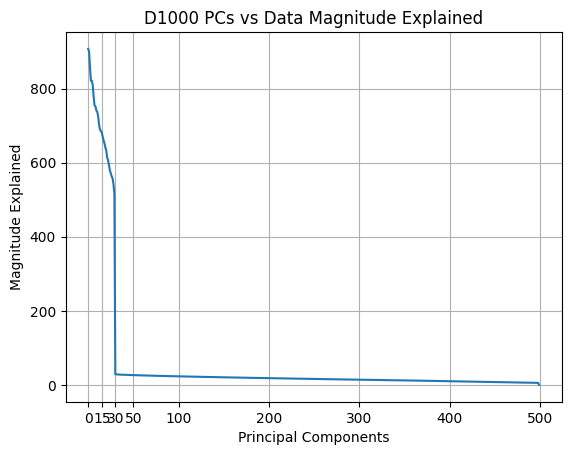

In [43]:
dro_diag = dro_pca(datakd,500,True)
plt.plot(np.arange(0,len(dro_diag)),dro_diag)
plt.xticks([0,15,30,50,100,200,300,400,500])
plt.xlabel("Principal Components")
plt.ylabel("Magnitude Explained")
plt.title("D1000 PCs vs Data Magnitude Explained")
plt.grid()

In [31]:
yk_hats, k_errors = eval_all_methods(datakd,d=30)

k_errors

{'buggy': 401365.69931017945,
 'demeaned': 136522.9794893014,
 'normed': 136814.2904988116,
 'dro': 136522.97948930142}

In [32]:
pd.DataFrame({
    "d2":errors,
    "d1000":k_errors
})

,d2,d1000
buggy,44.345154,401365.699310
demeaned,0.500304,136522.979489
normed,2.473604,136814.290499
dro,0.500304,136522.979489
